In [1]:
import pickle
import numpy as np
from keras.models import Model
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense, Concatenate, Lambda, Flatten
from keras.layers import Activation, BatchNormalization, Bidirectional
from keras.regularizers import l2
from keras.utils import to_categorical, plot_model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
Acts_all = ['1Approaching', '2Departing', '4Kicking', '3Pushing', '8Handshaking', '7Hugging', '6Exchanging', 
            '5Punching']

In [3]:
X = {}

for act in Acts_all:
    file = open('/' + act + '_v3.pickle', 'rb')
    data_dict = pickle.load(file)
    file.close()
    data_dict['topc'] = np.asarray(data_dict['topc'])
    data_dict['topw'] = np.asarray(data_dict['topw'])
    X[act] = data_dict    

In [4]:
for act in Acts_all:
    print(act, len(X[act]['topc']))

1Approaching 42
2Departing 43
4Kicking 41
3Pushing 40
8Handshaking 38
7Hugging 39
6Exchanging 21
5Punching 18


# Model

In [5]:
def create_model(n1, n2, num_classes):
    Xc = Input(shape = n1)
    Xw = Input(shape = n2)
    X = []

    rnn = LSTM(32, kernel_regularizer=l2(0.1), return_sequences=True)    
        
    for i in range(5):
        for j in range(5):
            x = Lambda(lambda x: x[:, :, i, j, :])(Xc)
            x = rnn(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            X.append(x)
            
    X.append(Xw)
    X = Concatenate()(X)
    
    X = LSTM(64, kernel_regularizer=l2(0.1), return_sequences=True)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = LSTM(64, kernel_regularizer=l2(0.1))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Dense(64, kernel_regularizer=l2(0.1))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Dense(64, kernel_regularizer=l2(0.1))(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    Y = Dense(num_classes, activation='softmax')(X)
    
    return Model(inputs=[Xc, Xw], outputs=Y)

In [6]:
n = len(X['1Approaching']['topc'])
n = int(n*0.75)
print(n)
print(len(X['1Approaching']['topc'][:n]))

print(len(X['1Approaching']['topc'][n:]))

31
31
11


# Training the Model

In [14]:
itrs = 1
num_class = len(Acts_all)

for _ in range(itrs):
    distinct = 0
    Xc_train, Xc_test, Xw_train, Xw_test, Y_train_rf, Y_test_rf = [], [], [], [], [], []
    test_size = []
    for act in Acts_all:                            ### Creating training(75%) and test(25%) set
        num = len(X[act]['topc'])
        num = int(num*0.75)
        test_size.append(len(X[act]['topc'])-num)
        Xc_train.extend(X[act]['topc'][:num])
        Xc_test.extend(X[act]['topc'][num:])
        Xw_train.extend(X[act]['topw'][:num])
        Xw_test.extend(X[act]['topw'][num:])
        Y_train_rf.extend([distinct for i in range(len(X[act]['topc'][:num]))])
        Y_test_rf.extend([distinct for i in range(len(X[act]['topc'][num:]))])
        distinct += 1
        
    Xc_train = np.asarray(Xc_train)     
    Xw_train = np.asarray(Xw_train)     
    Xc_test = np.asarray(Xc_test)     
    Xw_test = np.asarray(Xw_test)
    Y_train_rf = np.asarray(Y_train_rf)
    Y_test_rf = np.asarray(Y_test_rf)
    Y_train = to_categorical(Y_train_rf, num_class)
    Y_test = to_categorical(Y_test_rf, num_class)
    
    perm = np.random.permutation(Xc_train.shape[0])
    Xc_train = Xc_train[perm]
    Xw_train = Xw_train[perm]
    Y_train = Y_train[perm]
    Y_train_rf = Y_train_rf[perm]

    perm = np.random.permutation(Xc_test.shape[0])
    Xc_test = Xc_test[perm]
    Xw_test = Xw_test[perm]
    Y_test = Y_test[perm]
    Y_test_rf = Y_test_rf[perm]
    
    model = create_model(Xc_train.shape[1:], Xw_train.shape[1:], num_class)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     print(model.summary())
    history = model.fit([Xc_train, Xw_train], Y_train, batch_size=16, epochs=100)
    
    model_history = model.evaluate([Xc_train, Xw_train], Y_train)
    print(model_history)

    predictions = model.predict([Xc_test, Xw_test])
    predictions = np.argmax(predictions, axis=-1)
    acc = {act:0 for act in Acts_all}
    for i in range(len(predictions)):
        if predictions[i] == Y_test_rf[i]:
            acc[Acts_all[Y_test_rf[i]]] += 1
    i = 0
    for act in Acts_all:
        print ('%s: %.3f' % (act, (acc[act]/test_size[i])))
        print(test_size[i])
        i += 1

Epoch 1/100
208/208 [==============================] - 39s 188ms/step - loss: 42.4189 - acc: 0.1971
Epoch 2/100
208/208 [==============================] - 5s 22ms/step - loss: 29.3308 - acc: 0.2548
Epoch 3/100
208/208 [==============================] - 5s 24ms/step - loss: 19.9951 - acc: 0.3654
Epoch 4/100
208/208 [==============================] - 5s 25ms/step - loss: 14.0834 - acc: 0.3510
Epoch 5/100
208/208 [==============================] - 5s 26ms/step - loss: 10.4438 - acc: 0.3990
Epoch 6/100
208/208 [==============================] - 5s 26ms/step - loss: 8.1010 - acc: 0.4423
Epoch 7/100
208/208 [==============================] - 6s 27ms/step - loss: 6.4988 - acc: 0.4808
Epoch 8/100
208/208 [==============================] - 5s 26ms/step - loss: 5.4189 - acc: 0.5096
Epoch 9/100
208/208 [==============================] - 5s 24ms/step - loss: 4.7015 - acc: 0.4952
Epoch 10/100
208/208 [==============================] - 5s 24ms/step - loss: 4.1404 - acc: 0.4856
Epoch 11/100
208/208 [

Text(0, 0.5, 'Accuracy')

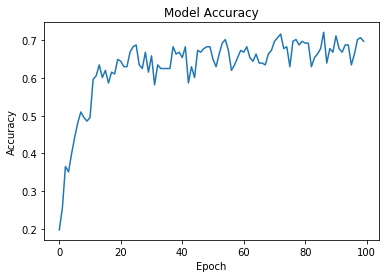

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')